In [ ]:
import numpy as np

# data I/O
data = open('/content/sample_data/shakespear.txt', 'r').read()  # assuming it's a simple plain text file
data = data.replace('\n', ' ')  # Remove newline characters
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('data has %d characters, %d unique.' % (data_size, vocab_size))
char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}


data has 99992 characters, 61 unique.


In [ ]:
from collections import Counter
char_occurrences = Counter(data)
total_length = len(data)
char_prob= {char: count / total_length for char, count in char_occurrences.items()}
len(char_prob)

61

In [ ]:
seq_length = 61 # number of steps to unroll the RNN for
p=0
targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]
real_y=[char_prob[ch] for ch in data[p+1:p+seq_length+1]]

In [ ]:
# hyperparameters
hidden_size = 200 # size of hidden layer of neurons
hidden_size2 = 100
hidden_size3 = 50
learning_rate = 1e-1

In [ ]:
def he_initialization(input_units, output_units):
    stddev = np.sqrt(2 / input_units)
    return np.random.randn(output_units, input_units) * stddev

In [ ]:
# model parameters
Wxh = he_initialization(vocab_size, hidden_size)*0.01
Wxh2 = he_initialization(hidden_size, hidden_size2)
Wxh3 = he_initialization(hidden_size2, hidden_size3)
Whh = he_initialization(hidden_size, hidden_size)*0.01
Whh2 = he_initialization(hidden_size2, hidden_size2)
Whh3 = he_initialization(hidden_size3, hidden_size3)
Why = he_initialization(hidden_size3, vocab_size)
bh = np.ones((hidden_size, 1)) # hidden bias
bh2 = np.ones((hidden_size2, 1)) # hidden bias
bh3 = np.ones((hidden_size3, 1)) # hidden bias
by = np.ones((vocab_size, 1)) # output bias

In [ ]:
def lossFun(inputs, targets, hprev, hprev2, hprev3):
    """
    inputs, targets are both lists of integers.
    hprev is Hx1 array of initial hidden state
    returns the loss, gradients on model parameters, and last hidden state
    """
    xs, hs, hs2, hs3, ys, ps = {}, {}, {}, {}, {}, {}
    hs[-1] = np.copy(hprev)
    hs2[-1] = np.copy(hprev2)
    hs3[-1] = np.copy(hprev3)
    loss = 0
    # forward pass
    for t in range(len(inputs)):
        xs[t] = np.zeros((vocab_size, 1))  # encode in 1-of-k representation
        xs[t][inputs[t]] = 1
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t - 1]) + bh)  # hidden state
        hs2[t] = np.tanh(np.dot(Wxh2, hs[t]) + np.dot(Whh2, hs2[t - 1]) + bh2)  # hidden state with ReLU
        hs3[t] = np.tanh(np.dot(Wxh3, hs2[t]) + np.dot(Whh3, hs3[t - 1]) + bh3)  # hidden state with ReLU
        ys[t] = np.dot(Why, hs3[t]) + by  # unnormalized log probabilities for next chars
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t]))  # probabilities for next chars
        loss += -np.log(ps[t][targets[t], 0])  # softmax (cross-entropy loss)
    # backward pass: compute gradients going backwards
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dWxh2, dWhh2, dWxh3, dWhh3 = np.zeros_like(Wxh2), np.zeros_like(Whh2), np.zeros_like(Wxh3), np.zeros_like(Whh3)
    dbh, dbh2, dbh3, dby = np.zeros_like(bh), np.zeros_like(bh2), np.zeros_like(bh3), np.zeros_like(by)
    dhnext = np.zeros_like(hs[0])
    dhnext2 = np.zeros_like(hs2[0])
    dhnext3 = np.zeros_like(hs3[0])
    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t])# backprop into y
        dy[targets[t]] -= 1
        # Backpropagation through the output layer
        dWhy += np.dot(dy, hs3[t].T)
        dby += dy

        # backprop into hs3
        dh3 = np.dot(Why.T, dy) + dhnext3
        dhraw3 = (1 - hs3[t] * hs3[t]) * dh3
        dbh3 += dhraw3
        dWxh3 += np.dot(dhraw3, hs2[t].T)
        dWhh3 += np.dot(dhraw3, hs3[t - 1].T)
        dhnext3 = np.dot(Whh3.T, dhraw3)

        # backprop into hs2
        dh2 = np.dot(Wxh3.T,dh3)+ dhnext2
        dhraw2 = (1 - hs2[t] * hs2[t])* dh2
        dbh2 += dhraw2
        dWxh2 += np.dot(dhraw2, hs[t].T)
        dWhh2 += np.dot(dhraw2, hs2[t - 1].T)
        dhnext2 = np.dot(Whh2.T, dhraw2)

        # backprop into hs1
        dh = np.dot(Wxh2.T,dh2)+ dhnext
        dhraw = (1 - hs[t] * hs[t])*dh
        dbh += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t - 1].T)
        dhnext = np.dot(Whh.T, dhraw)

    for dparam in [dWxh, dWhh, dWhy, dbh, dby, dWxh2, dWhh2, dWxh3, dWhh3, dbh2, dbh3]:
        np.clip(dparam, -5, 5, out=dparam)  # clip to mitigate exploding gradients
    return loss, dWxh,dWxh2,dWxh3, dWhh,dWhh2,dWhh3, dWhy, dbh,dbh2,dbh3, dby, hs[len(inputs) - 1], hs2[len(inputs) - 1], hs3[len(inputs) - 1]


In [ ]:
def sample(h,h2,h3,seed_ix, n):
  """
  sample a sequence of integers from the model
  h is memory state, seed_ix is seed letter for first time step
  """
  x = np.zeros((vocab_size, 1))
  x[seed_ix] = 1
  ixes = []
  for t in range(n):
    h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
    h2= np.tanh(np.dot(Wxh2, h) + np.dot(Whh2, h2) + bh2)
    h3= np.tanh(np.dot(Wxh3, h2) + np.dot(Whh3, h3) + bh3)
    y = np.dot(Why, h3) + by
    p = np.exp(y) / np.sum(np.exp(y))
    ix = np.argmax(p)
    x = np.zeros((vocab_size, 1))
    x[ix] = 1
    ixes.append(ix)
  return ixes

In [ ]:
n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mWxh2, mWhh2, mWxh3, mWhh3 = np.zeros_like(Wxh2), np.zeros_like(Whh2), np.zeros_like(Wxh3), np.zeros_like(Whh3)
mbh, mbh2, mbh3, mby = np.zeros_like(bh), np.zeros_like(bh2), np.zeros_like(bh3), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0
losses=[]
lr=0.01
while n<20000:#trainig for nearly 10 epoch note I used 1_batch gradient descent
  if p +seq_length >= len(data) or n == 0:
    hprev = np.zeros((hidden_size,1))
    hprev2 = np.zeros((hidden_size2,1))
    hprev3 = np.zeros((hidden_size3,1))
    p = 0 # go from start of data
  inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
  targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]
  real_y=[char_prob[ch] for ch in data[p+1:p+seq_length+1]]

  # sample from the model now and then
  if n % 4000 == 0 or n==19999:
    sample_ix = sample(hprev, hprev2, hprev3, inputs[0], 200)
    txt = ''.join(ix_to_char[ix] for ix in sample_ix)
    print ('----\n %s \n----' % (txt, ))
    lr*=0.9

  # forward seq_length characters through the net and fetch gradient
  loss, dWxh, dWxh2, dWxh3, dWhh, dWhh2, dWhh3, dWhy, dbh, dbh2, dbh3, dby, hprev, hprev2, hprev3 = lossFun(inputs, targets,hprev, hprev2, hprev3)
  smooth_loss = smooth_loss * (1-lr) + loss * lr
  if n % 2000 == 0: #nearly equivalent to 1 epoch
    print ('iter %d, loss: %f' % (n, smooth_loss)) # print progress
  losses.append(smooth_loss)

  # perform parameter update with Adagrad
  for param, dparam, mem in zip([Wxh, Whh, Why, bh, by, Wxh2, Whh2, Wxh3, Whh3, bh2, bh3],
                               [dWxh, dWhh, dWhy, dbh, dby, dWxh2, dWhh2, dWxh3, dWhh3, dbh2, dbh3],
                               [mWxh, mWhh, mWhy, mbh, mby, mWxh2, mWhh2, mWxh3, mWhh3, mbh2, mbh3]):
    mem += dparam * dparam
    param += -learning_rate * dparam / (np.sqrt(mem) + 1e-8)

  p += seq_length # move data pointer
  n += 1 # iteration counter

----
 hor tot th ther the the thath the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the th 
----
iter 0, loss: 249.899410
iter 2000, loss: 155.644634
----
 nd the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the t 
----
iter 4000, loss: 148.617375
iter 6000, loss: 149.228152
----
  the the the to the the the to the the the to the the the to the the the to the the the to the the the to the the the to the the the to the the the to the the the to the the the to the the the to the  
----
iter 8000, loss: 146.927242
iter 10000, loss: 145.956664
----
  the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 

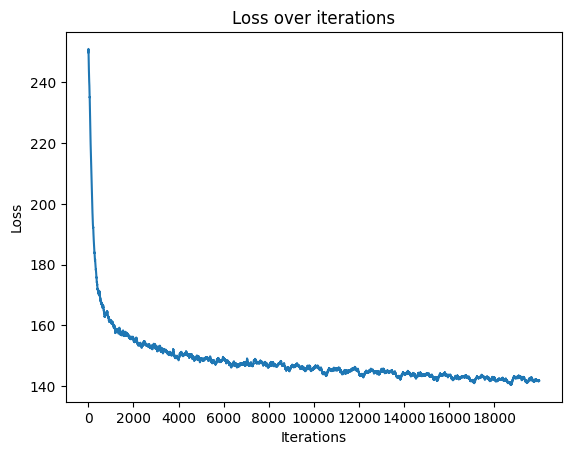

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss over iterations')

plt.xticks(range(0, len(losses), 2000))

plt.show()

In [ ]:
sample_ix = sample(hprev, hprev2, hprev3, 25, 10)
txt = ''.join(ix_to_char[ix] for ix in sample_ix)
print ('----\n %s \n----' % (txt, ))

----
  the the s 
----


#Comment: we can get better results by changing data more bigger here the main objective of this code was to implement RNN from scratch